In [70]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd
import h5py

from matplotlib import pyplot as plt, cm

from common import dalt
from common import hallmark as hm
from common import viz
#from common.shadow import *
#from common import analyses as nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def colorbar(mappable):
    """ the way matplotlib colorbar should have been implemented """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

def readimg(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['pol'][:]
    return dalt.Image(data, meta=meta)

def show(vs, s=0, f=None, ax=None, labels=True, quiver=False,**kwargs):
    cmap = 'afmhot'
    vmin = None
    vmax = None
    extent = vs.extent

    tauF = vs.tauF
    tauI = vs.tauI
    extent_labels = vs.extent_labels

    vs = vs.transpose((1,0,2))
    if vs.ndim != 2:
        if s is None:
            raise ValueError('must specify snapshot number for movie')
        I = vs[:,:,0].value
        Q = vs[:,:,1].value
        U = vs[:,:,2].value
        V = vs[:,:,3].value

        evpa = 0.5*np.arctan2(U,Q)*(180/3.14159)
        evpa = evpa + 90
        evpa[evpa > 90.] = evpa[evpa > 90.] - 180.
        Imaskval = np.nanmax(I) / np.power(I.shape[0],5.)


        fov_muas = 200
        extent = [-fov_muas/2, fov_muas/2, -fov_muas/2, fov_muas/2 ]
        
        if s == 0: # Intensity
            v = I
            if quiver:
                npix = I.shape[0]
                xs = np.linspace(extent[0], extent[1], npix)
                Xs,Ys = np.meshgrid(xs,xs)
                lpscal = np.max(np.sqrt(Q*Q+U*U))
                vxp = np.sqrt(Q*Q+U*U)*np.sin(evpa*3.14159/180.)/lpscal
                vyp = -np.sqrt(Q*Q+U*U)*np.cos(evpa*3.14159/180.)/lpscal
                skip = int(npix/32) 
                ax.quiver(Xs[::skip,::skip],Ys[::skip,::skip],vxp[::skip,::skip],vyp[::skip,::skip], 
                headwidth=1, headlength=1, 
                width=0.005,
                color='#00ff00', 
                units='width', 
                scale=4,
                pivot='mid')
        if s == 1: # linear polarization fraction
            lpfrac = np.sqrt(Q*Q+U*U)/I * 100
            v = lpfrac
            vmax=100
            vmin = 0
            cmap = 'jet'
        if s == 1.5: # linear polarization
            lpfrac = np.sqrt(Q*Q+U*U)
            v = lpfrac
            vmin = 0
            cmap = 'jet'
        if s == 2: # Circular polarization fraction
            cpfrac = 100.*V/I
            vext = max(np.abs(np.nanmin(cpfrac)),np.abs(np.nanmax(cpfrac)))
            vext = max(vext, 1.)
            vmax = vext
            v = cpfrac
            vmin = -vext
            cmap = 'seismic'
        if s == 2.5: # Circular polarization
            cpfrac = V
            vext = max(np.abs(np.nanmin(cpfrac)),np.abs(np.nanmax(cpfrac)))
            vmax = vext
            v = cpfrac
            vmin = -vext
            cmap = 'seismic'
        if s == 3:
            v = np.sqrt(Q*Q + U*U + V*V) / I * 100
            vmin = 0
            vmax = 100
            cmap = 'jet'
        if s == 4: # Faraday optical depth
            v = tauF
        if s == 5: # Optical depth
            v = tauI
        if s == 6:
            evpa2 = np.copy(evpa)
            evpa2[np.abs(I)<Imaskval] = np.nan
            ax3.set_facecolor('black')
            im3 = ax3.imshow(evpa2, cmap='hsv', vmin=-90., vmax=90., origin='lower', extent=extent, interpolation='none')
            colorbar(im3)
    else:
        v = vs
    
    if f is None:
        f = lambda x: x

    if ax is None:
        fig, ax = plt.subplots(1, 1)
    if vmin is not None and vmax is not None:
        img = ax.imshow(f(v), origin='lower', extent=extent, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    else:
        img = ax.imshow(f(v), origin='lower', extent=extent, cmap=cmap, **kwargs)
    colorbar(img)

    if labels:
        labels = extent_labels
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])

    return ax

def plot(ax, pf, **kwargs):
    if len(pf) != 1:
        return

    img = readimg(pf.path.iloc[0])
    show(img, ax=ax,labels=False, **kwargs)

    ax.tick_params(color='w')
    for spine in ax.spines.values():
        spine.set_edgecolor('w')

def vizrow(pf, left_label=None, **kwargs):
    fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0)

    if True:
        for a, ax in enumerate(axes):
            sel = pf(aspin=aspin[a])
            ax = axes[a]
            ax.set_title(f"$a_\mathrm{{spin}}={aspin[a]}$")

            plot(ax, sel, **kwargs)

            ax.tick_params(
                axis='both',
                direction='in',
                top=True,
                right=True,
                color='w',
            )

        plt.tight_layout()

    if left_label is not None:
        axes[0].set_ylabel(left_label)

In [72]:
pf_SPO = hm.ParaFrame('cache/SPO/avg/{NGC}_a{aspin:g}_i{inc:g}_f{freq}.h5')
#pf = hm.ParaFrame('/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/SgrA_constraints/illinois_avg/avg_Rh40_{freq}_a{aspin}_i{inc}.h5')

pf_beta = hm.ParaFrame('cache/beta/avg/{NGC}_a{aspin:g}_i{inc:g}_f{freq}_Rh{Rh}.h5')
for k in set(pf_SPO.keys()) - {'path'}:
    globals()[k] = np.unique(pf_SPO[k])
    print(k, globals()[k][:16])

inc [30.]
freq ['136.e12' '230.e9' '86.e9']
NGC ['SgrA']
aspin [-0.94 -0.5   0.    0.5   0.94]


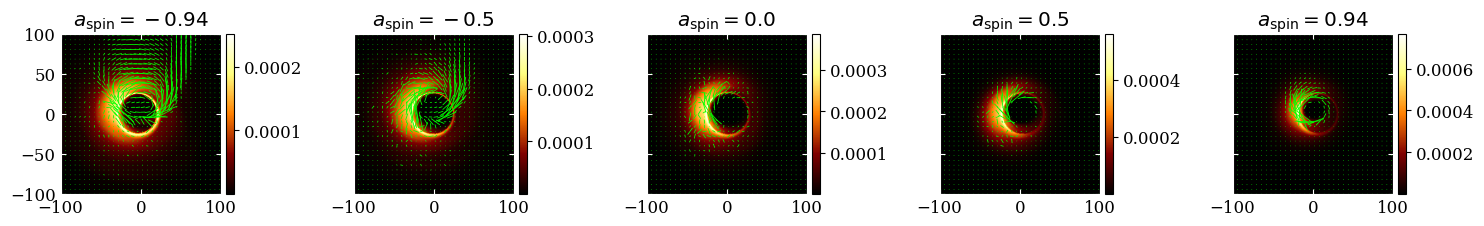

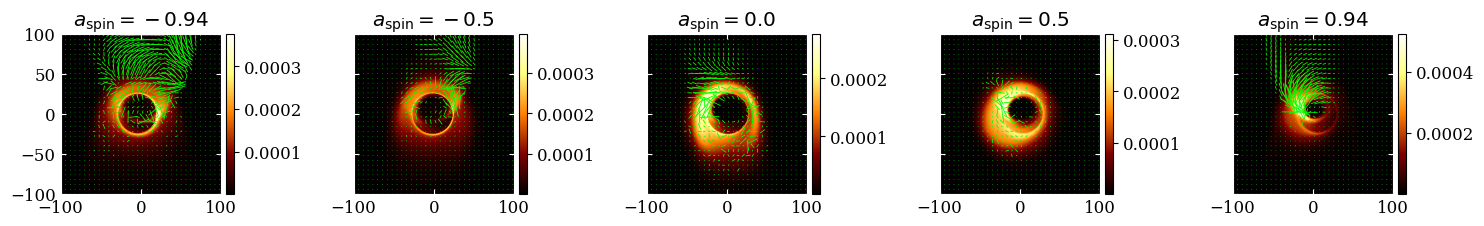

In [85]:
# Linear Polarization Quiver with Intensity Map
vizrow(pf_SPO(freq='230.e9'), s=0,quiver=True,)
vizrow(pf_beta(freq='230.e9'), s=0,quiver=True,)

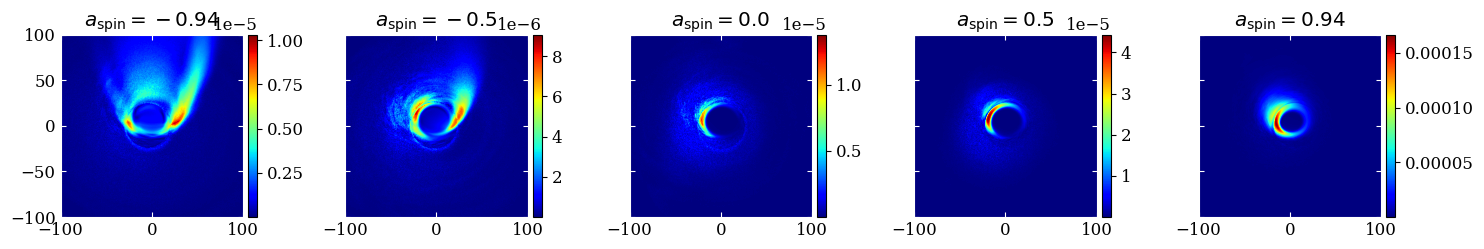

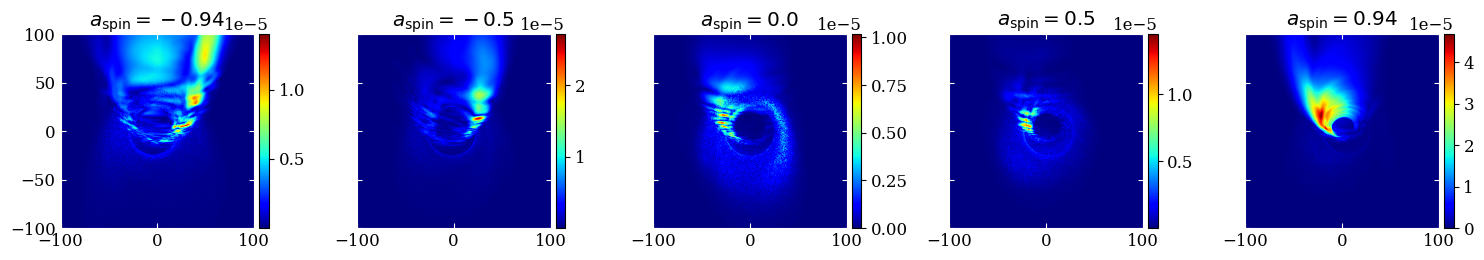

In [87]:
# Linear Polarization Fraction
vizrow(pf_SPO(freq='230.e9'), s=1.5,quiver=True,)
vizrow(pf_beta(freq='230.e9'), s=1.5,quiver=True,)

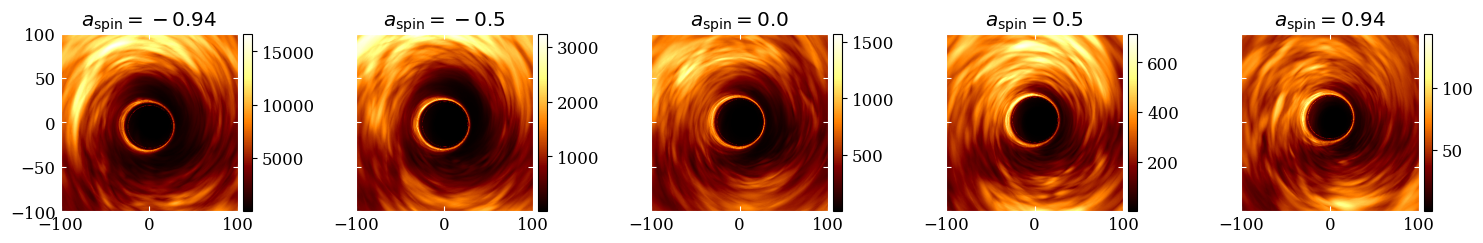

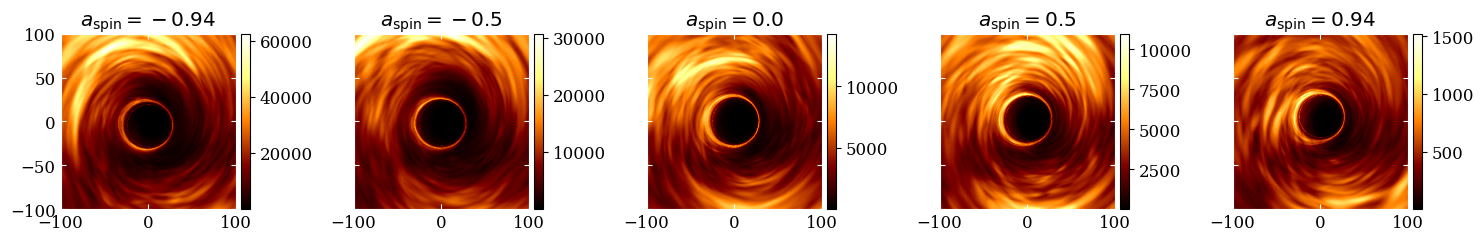

In [89]:
# Faraday Depth
vizrow(pf_SPO(freq='230.e9'), s=4,)
vizrow(pf_beta(freq='230.e9'), s=4,)

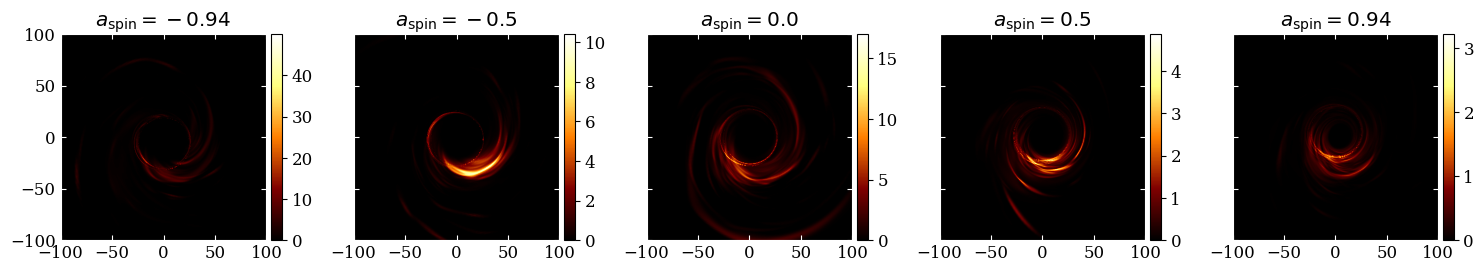

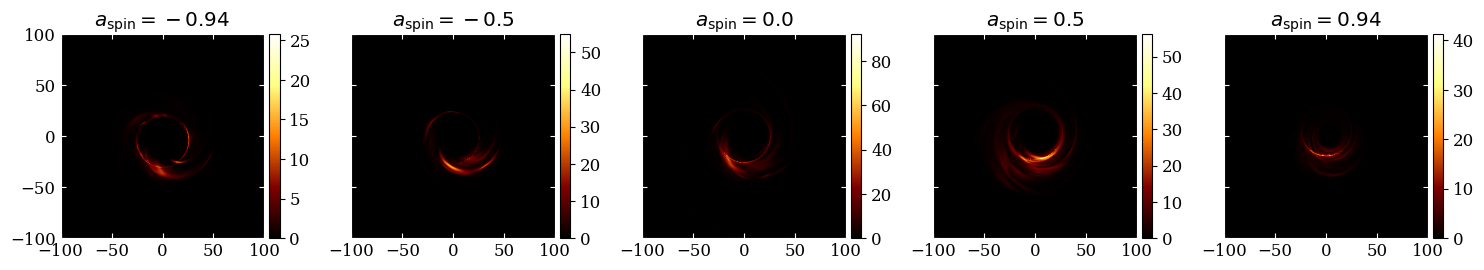

In [90]:
# Optical Depth
vizrow(pf_SPO(freq='230.e9'), s=5,)
vizrow(pf_beta(freq='230.e9'), s=5,)

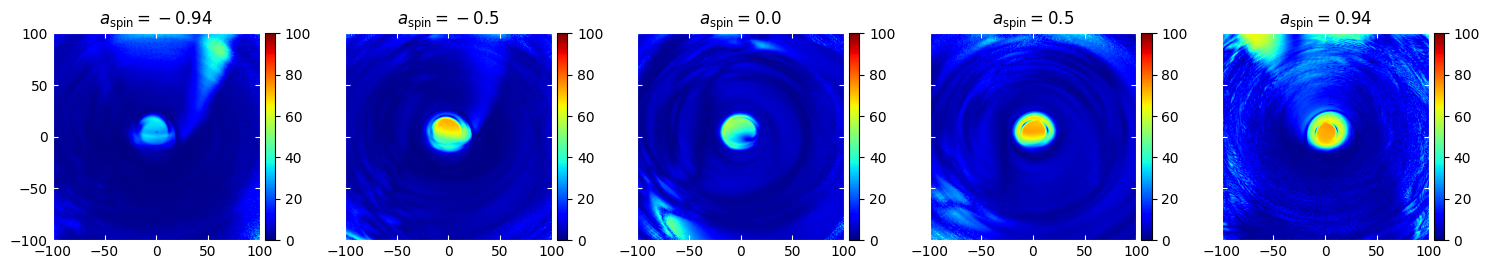

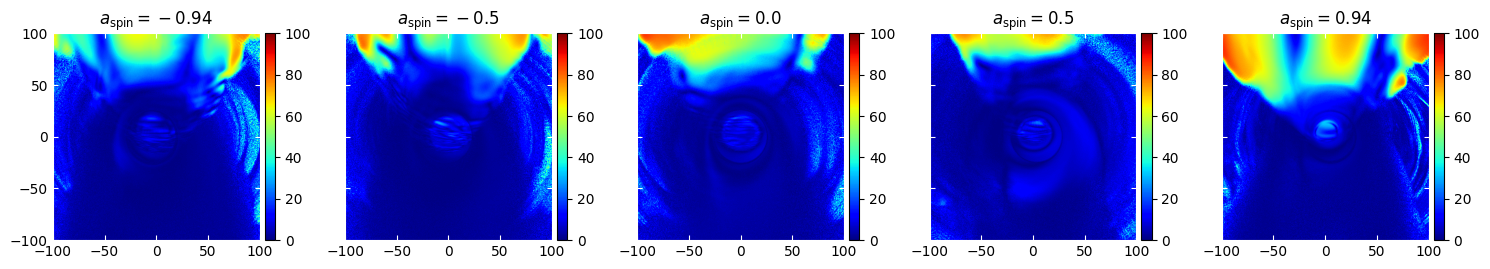

In [ ]:
vizrow(pf_SPO(freq='230.e9'), s=3, quiver=True, )
vizrow(pf_beta(freq='230.e9')(Rh='40'), s=3, quiver=True, )

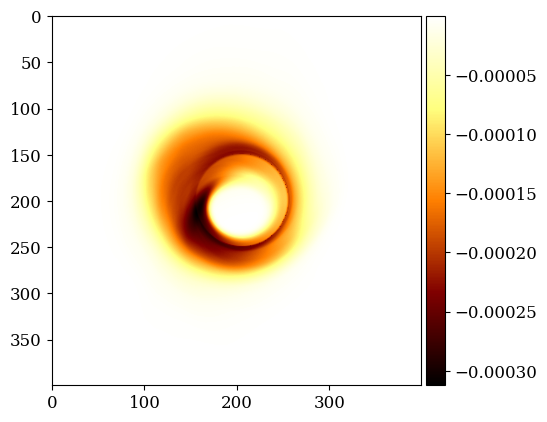

In [ ]:
img_SPO = readimg(pf_SPO.path.iloc[0]).transpose((1,0,2))
img_beta = readimg(pf_beta.path.iloc[0]).transpose((1,0,2))

I_SPO = img_SPO[:,:,0].value
I_beta = img_beta[:,:,0].value

temp = (I_SPO - I_beta)

fig, ax = plt.subplots(1)
colorbar(ax.imshow(temp, cmap='afmhot'))

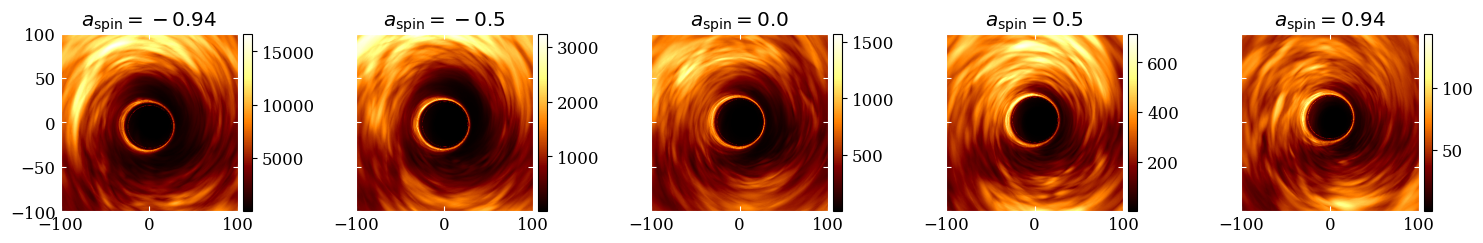

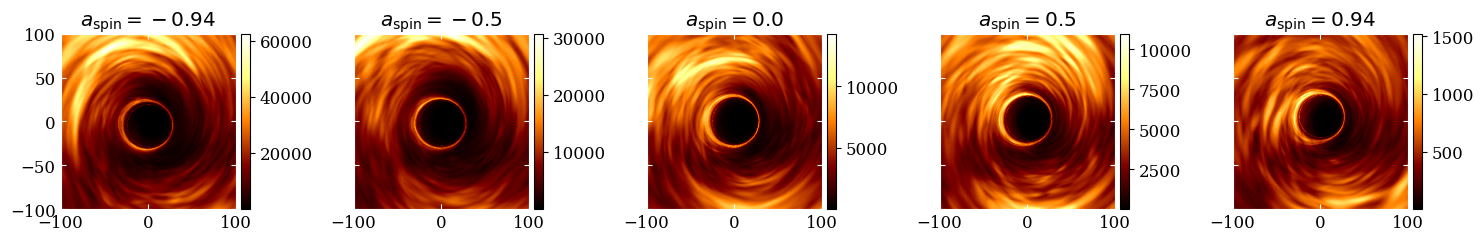

In [ ]:
vizrow(pf_SPO(freq='230.e9'), s=4)
vizrow(pf_beta(freq='230.e9'), s=4,)

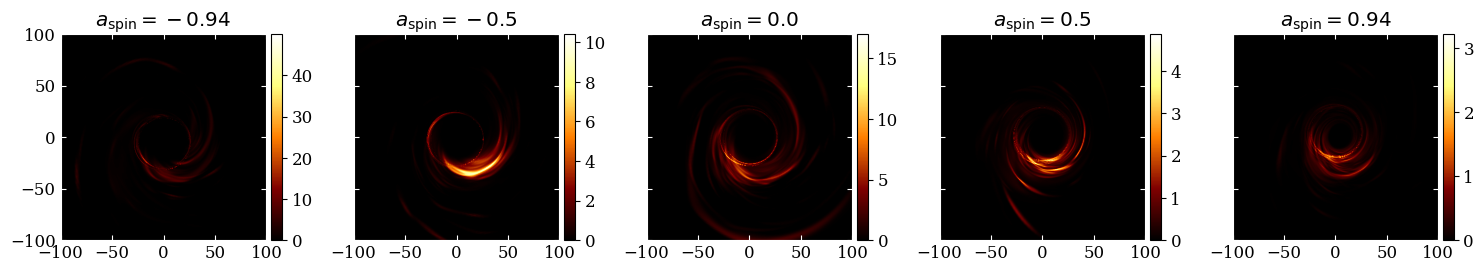

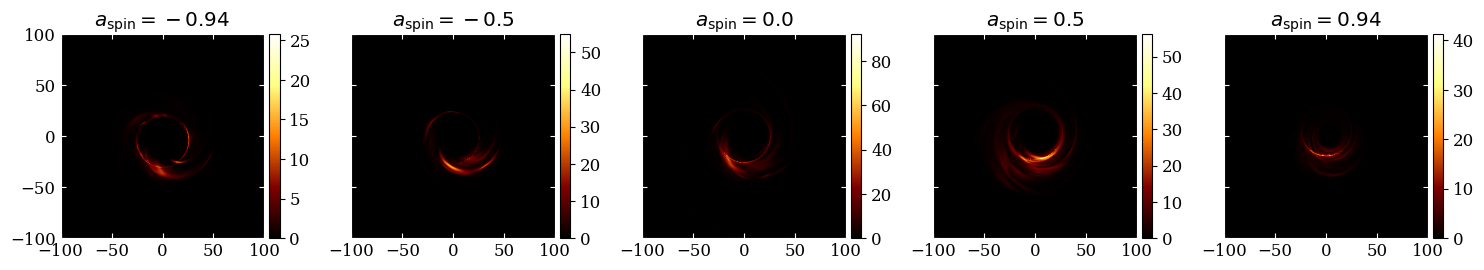

In [77]:
vizrow(pf_SPO(freq='230.e9'), s=5)
vizrow(pf_beta(freq='230.e9'), s=5,)

# Use of ehtim to find the structural parameters
depreciated as the symmetric assumption is not useful in assymetric ring

In [ ]:
from ehtim import io
from ehtim import rex

SPO_snapshot_path = '/Users/caritsang/project/2024SURE/dump/snapshot/SPO_5000.h5'
beta_snapshot_path = '/Users/caritsang/project/2024SURE/dump/snapshot/beta_5000.h5'

Welcome to eht-imaging! v 1.2.8 

Loading hdf5 image:  /Users/caritsang/project/2024SURE/dump/snapshot/SPO_5000.h5
nrays 25 nrs 50 fov 0.1 n 10
compute profile


In [38]:
def get_ehtim_info(pp, spin):
    return [spin, pp.RingSize1_med[0], pp.RingAngle1[0], pp.RingWidth[0], pp.RingAsym1[0], pp.in_level / pp.meanpk]

def add_header(avg_path):
    with h5py.File(avg_path, 'a') as avg_h:     
        with h5py.File(SPO_snapshot_path, 'r') as h1:
            if 'header' not in avg_h:
                h1.copy('header', avg_h)  # copies 'header' group or dataset from h1 into h2
            if 'pol' not in avg_h:
                avg_h.copy('data', 'pol')
                del avg_h['data']

def mk_structure_df(pf):

    tmp = []
    for spin in aspin:
        im = io.load.load_im_hdf5(pf(aspin=spin)(freq='230.e9').path.iloc[0])
        prof = rex.FindProfile(im)
        tmp.append(get_ehtim_info(prof, spin))

    df = pd.DataFrame(tmp, columns=['spin', 'd', 'eta', 'w', 'A', 'f',])

    return df

def plot_ring(path):
    im = io.load.load_im_hdf5(path)
    prof = rex.FindProfile(im)
    prof.plot_img()

In [39]:
df_SPO = mk_structure_df(pf_SPO)
df_beta = mk_structure_df(pf_beta)

Loading hdf5 image:  cache/SPO/avg/SgrA_a-0.94_i30_f230.e9.h5
nrays 25 nrs 50 fov 0.1 n 10
compute profile
Loading hdf5 image:  cache/SPO/avg/SgrA_a-0.5_i30_f230.e9.h5
nrays 25 nrs 50 fov 0.1 n 10
compute profile
Loading hdf5 image:  cache/SPO/avg/SgrA_a0_i30_f230.e9.h5
nrays 25 nrs 50 fov 0.1 n 10
compute profile
Loading hdf5 image:  cache/SPO/avg/SgrA_a+0.5_i30_f230.e9.h5
nrays 25 nrs 50 fov 0.1 n 10
compute profile
Loading hdf5 image:  cache/SPO/avg/SgrA_a+0.94_i30_f230.e9.h5
nrays 25 nrs 50 fov 0.1 n 10
compute profile
Loading hdf5 image:  cache/beta/avg/SgrA_a-0.94_i30_f230.e9_Rh40.h5
nrays 25 nrs 50 fov 0.1 n 10
compute profile
Loading hdf5 image:  cache/beta/avg/SgrA_a-0.5_i30_f230.e9_Rh40.h5
nrays 25 nrs 50 fov 0.1 n 10
compute profile
Loading hdf5 image:  cache/beta/avg/SgrA_a0_i30_f230.e9_Rh40.h5
nrays 25 nrs 50 fov 0.1 n 10
compute profile
Loading hdf5 image:  cache/beta/avg/SgrA_a+0.5_i30_f230.e9_Rh40.h5
nrays 25 nrs 50 fov 0.1 n 10
compute profile
Loading hdf5 image:  cach

In [40]:
df_SPO

,spin,d,eta,w,A,f
0,-0.94,45.301665,4.067677,7.369033,0.405621,0.255463
1,-0.50,46.719817,4.198989,4.695522,0.474391,0.056957
2,0.00,47.740494,4.570729,4.997536,0.587781,0.002033
3,0.50,50.725910,4.685150,11.290166,0.533821,0.004044
4,0.94,47.304356,4.859405,10.411217,0.439716,0.004849


In [41]:
df_beta

,spin,d,eta,w,A,f
0,-0.94,46.679027,2.480804,10.864846,0.284632,0.538833
1,-0.50,46.308248,3.503846,9.937574,0.285298,0.365398
2,0.00,42.420877,4.756166,20.374718,0.370912,0.624039
3,0.50,50.302033,4.899412,21.431902,0.203813,0.019252
4,0.94,40.471812,4.585805,16.619375,0.462253,0.098162


Loading hdf5 image:  cache/SPO/avg/SgrA_a-0.5_i30_f230.e9.h5
nrays 25 nrs 50 fov 0.1 n 10
compute profile


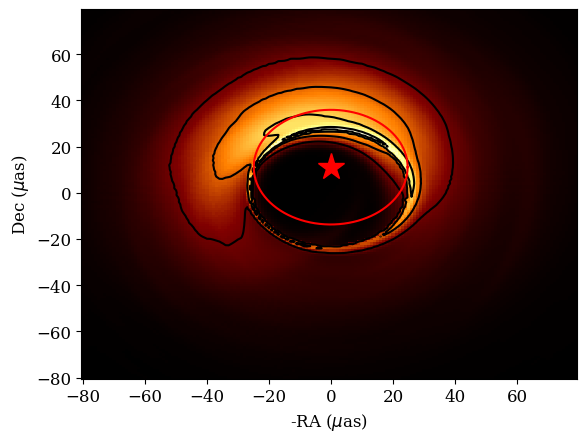

Loading hdf5 image:  cache/beta/avg/SgrA_a-0.5_i30_f230.e9_Rh40.h5
nrays 25 nrs 50 fov 0.1 n 10
compute profile


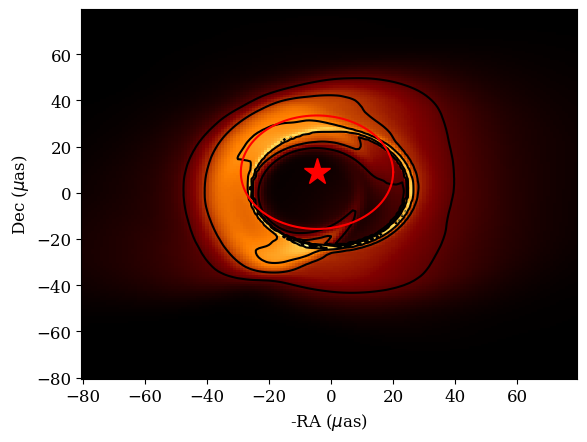

In [84]:
plot_ring(pf_SPO(aspin=-0.5)(freq='230.e9').path.iloc[0])
plot_ring(pf_beta(aspin=-0.5)(freq='230.e9').path.iloc[0])